# Curso de Manejo de Datos Faltantes: Imputación

[![Curso creado por jvelezmagic](https://img.shields.io/badge/Desarrollado%20por-%40jvelezmagic-blue?&style=for-the-badge&logo=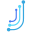)](https://jvelezmagic.com/)

![Curso de Manejo de Datos Faltantes: Exploración](./course-logo.jpg)

## Configuración de ambiente de trabajo

```bash
pip install --upgrade pip
```

```bash
pip install pyjanitor matplotlib missingno nhanes pandas scipy seaborn session-info sklearn statsmodels upsetplot
```

or 

```bash
pip install -r requirements.txt
```

## Importar librerías

In [2]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

## Importar funciones personalizadas

In [3]:
%run pandas-missing-extension.ipynb

## Configurar el aspecto general de las gráficas del proyecto

In [4]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

## El problema de trabajar con valores faltantes

In [5]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type = "snake"
    )
    .add_column("year", 1973)
    .assign(
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by = "date")
    .set_index("date")
)

airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [6]:
(
    smf.ols(formula="temp ~ ozone", data=airquality_df)
    .fit().summary().tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Wed, 01 Feb 2023",Prob (F-statistic):,2.93e-18
Time:,08:38:40,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [7]:
(
    smf.ols(formula="temp ~ ozone + solar_r", data=airquality_df)
    .fit().summary().tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Wed, 01 Feb 2023",Prob (F-statistic):,1.47e-16
Time:,08:38:40,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


### Reto: Datos de supervivientes

In [8]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data

In [9]:
survival_df

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.700,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.870,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.360,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.420,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.320,1.690,6,1.1,0,1039,1,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,52,F,1995,1.210,1.610,6,1.0,0,4997,0,NaN
7870,52,F,1999,0.858,0.581,1,0.8,0,3652,0,NaN
7871,54,F,2002,1.700,1.720,8,NaN,0,2507,0,NaN
7872,53,F,1995,1.710,2.690,9,NaN,0,4982,0,NaN


<AxesSubplot:>

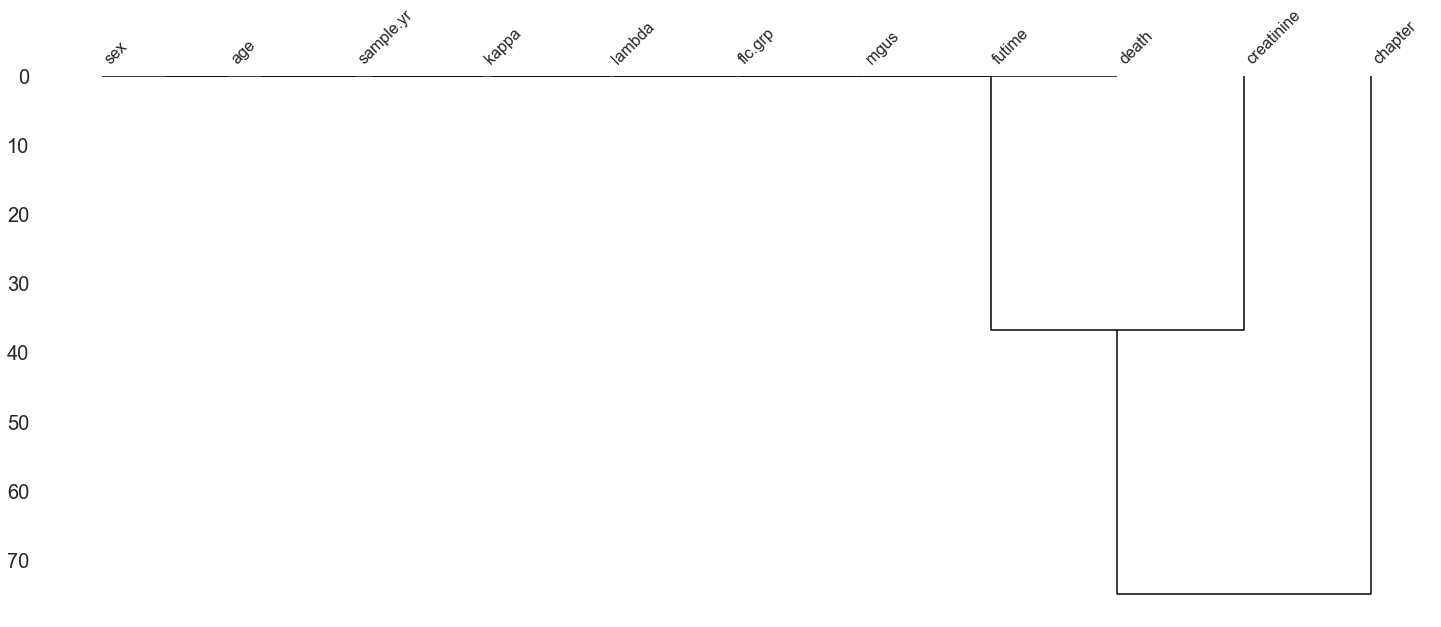

In [10]:
missingno.dendrogram(survival_df)

Ajusta algunos modelos utilizando a las variables con valores faltantes como predictoras. ¿Qué sucede?

In [11]:
# Aquí tu código...
(
    smf.ols(formula="death ~ futime", data=survival_df)
    .fit().summary()
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  death   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     5456.
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        08:38:41   Log-Likelihood:                -2755.2
No. Observations:                7874   AIC:                             5514.
Df Residuals:                    7872   BIC:                             5528.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0059      0.011     94.723      0.000       0.985       1.027
futime        -0.0002    2.7e-06    -73.863      0.000      -0.000      -0.000
==============================================================================
Omnibus:                      481.567   Durbin-Watson:                   1.664
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              704.694
Skew:                           0.528   Prob(JB):                    9.50e-154
Kurtosis:                       4.017   Cond. No.                     1.08e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Preparando datos: _National Health and Nutrition Examination Survey_

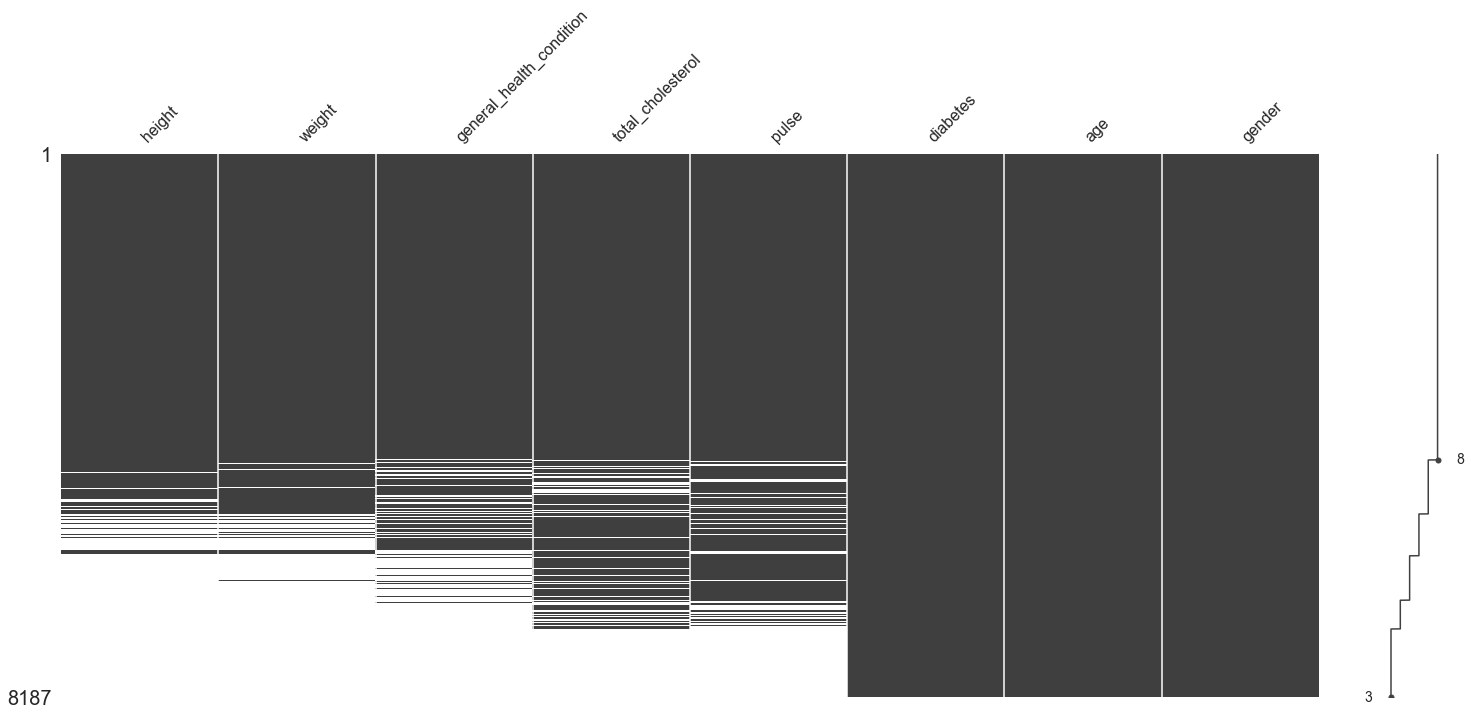

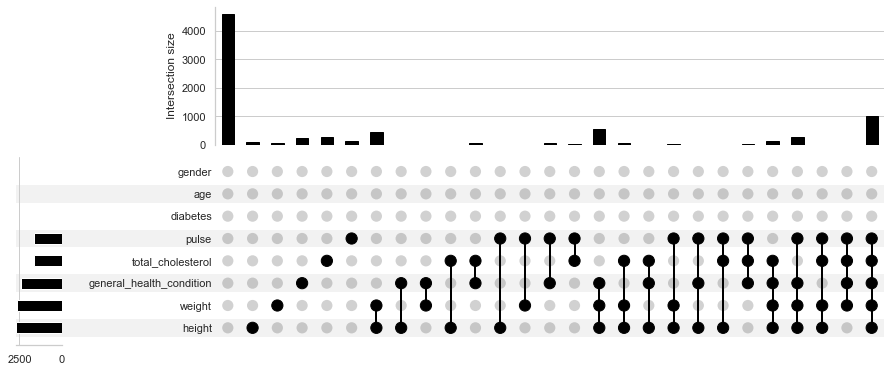

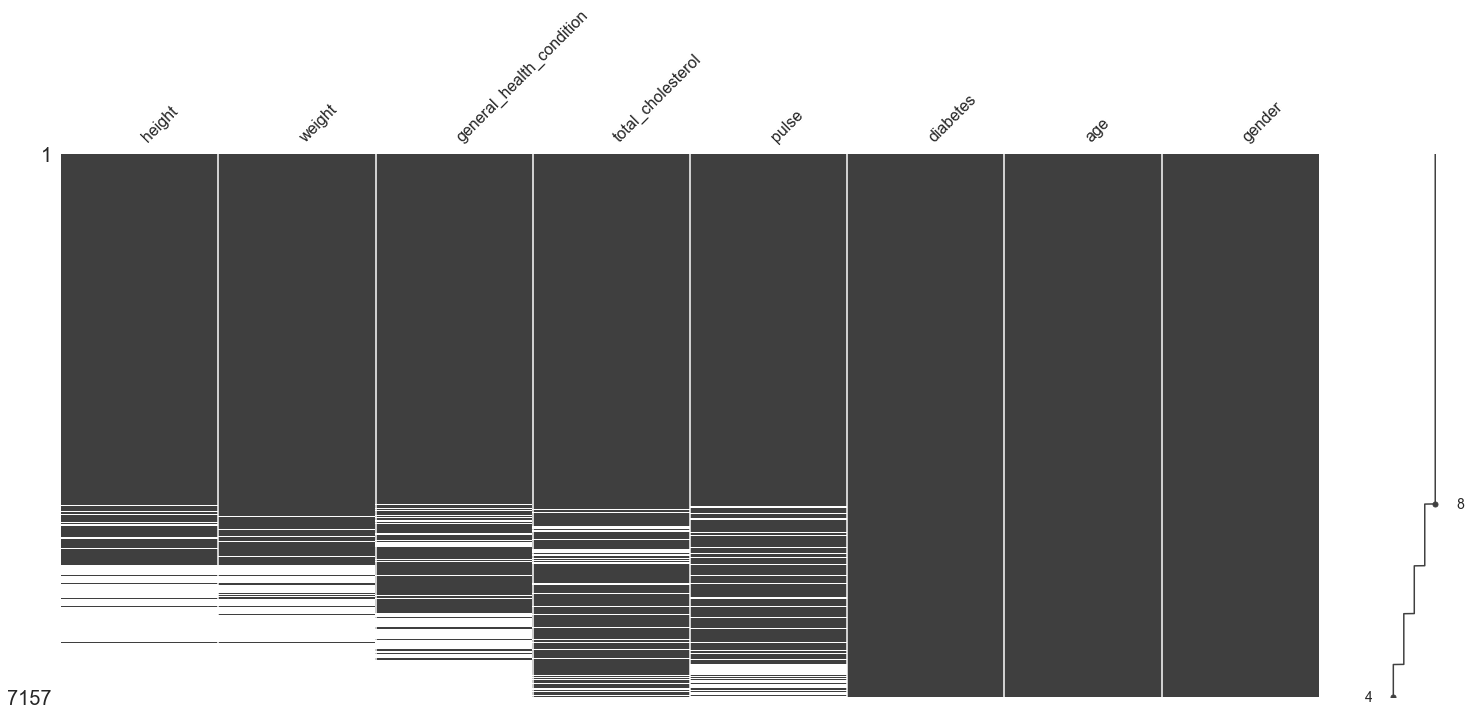

In [12]:
%run live-download-data-and-load-it.ipynb

## Consideración y evaluación de los distintos tipos de valores faltantes

![](../missing_data_action.jpeg)

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
<code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.<br>
<code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
<code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
    </p>
</div>

In [13]:
female_weight, male_weight = (
    nhanes_df
    .select_columns("gender","weight")
    .transform_column("weight", lambda x: x.isna(), elementwise = False)
    .groupby("gender").weight.pipe( 
        lambda df: (
        df.get_group("Female"),
        df.get_group("Male")
        )
    )
)

scipy.stats.ttest_ind(
    a = female_weight,
    b= male_weight,
    alternative="two-sided"
)

Ttest_indResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239)

## Amplía tu conjunto de herramientas para explorar valores faltantes

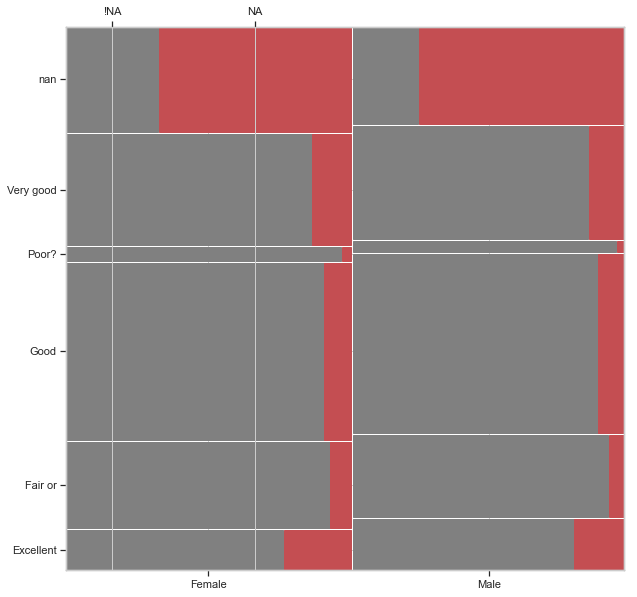

In [14]:
fig, ax = plt.subplots(figsize=(10,10))

(
    nhanes_df
    .select_columns("weight","general_health_condition","gender")
    .assign(
        weight = lambda df: df.weight.isna().replace([True, False], ["NA","!NA"])
    )
    .groupby(
        ["gender","general_health_condition","weight"],
        dropna=False,
        as_index=True
        )
        .size()
        .pipe(
            lambda df: mosaic(
                data= df,
                properties= lambda key: {"color": "r" if "NA" in key else "gray"},
                horizontal=True,
                axes_label=True,
                title="",
                labelizer= lambda key: "",
                ax=ax
            )
        )
);

In [15]:
nhanes_df

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


## Tratamiento de variables categóricas para imputación de valores faltantes

In [16]:
nhanes_transform_df = nhanes_df.copy(deep=True)

### Codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
    Una codificación ordinal <b>implica</b> mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
    </p>
</div>

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal.

In [17]:
encoder = sklearn.preprocessing.OrdinalEncoder()
X = [["Male"],["Female"],["Female"]]
X

[['Male'], ['Female'], ['Female']]

In [18]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [19]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [20]:
encoder.inverse_transform([[1],[0],[0]])

array([['Male'],
       ['Female'],
       ['Female']], dtype=object)

#### Aplicando la codificación ordinal a todas tus variables categóricas

In [21]:
categorical_columns = nhanes_df.select_dtypes(include=[object,"category"]).columns

In [22]:
categorical_transform = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder="passthrough"
)

In [23]:
categorical_transform

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 Index(['general_health_condition', 'gender'], dtype='object'))])

In [24]:
nhanes_df

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


In [25]:
nhanes_transform_df = (
    pd.DataFrame(
        categorical_transform.fit_transform(nhanes_df),
        columns= nhanes_df.columns,
        index= nhanes_df.index
    )
    # .rename_columns(
    #     function = lambda x: x.removeprefix("ordinalencoder__")
    # )
)

In [26]:
(
    nhanes_df
    .gender
    .values
    .reshape(-1,1)
)

array([['Female'],
       ['Male'],
       ['Male'],
       ...,
       ['Female'],
       ['Female'],
       ['Male']], dtype=object)

In [27]:
gender_encoder = sklearn.preprocessing.OrdinalEncoder()

gender_values = (
    nhanes_df
    .gender
    .values
    .reshape(-1, 1) # -1 parameter allow numpy to determine the dimension
)

(
    gender_encoder
    .fit_transform(
        X = gender_values
    )
    .squeeze()
)

(
    nhanes_df.gender.unique(),
    nhanes_transform_df.gender.unique(),
    gender_encoder.categories_
)

(array(['Female', 'Male'], dtype=object),
 array([66., 18., 13., 75., 56., 67., 54., 71., 61., 22., 45., 60., 70.,
        53., 42., 57., 20., 72., 11., 52.,  8., 26.,  9., 10., 25.,  7.,
        73., 64., 63., 55., 44., 74., 40., 19., 36., 80.,  6., 69., 41.,
        47., 32., 46., 21., 34., 31., 12., 62., 14., 24., 16., 58., 68.,
        38., 48., 35., 50., 28., 29., 43., 76., 37., 59., 30., 27., 15.,
        39., 33., 23., 79., 17., 78., 49., 77., 51., 65.]),
 [array(['Female', 'Male'], dtype=object)])

### _One Hot Encoding_

In [28]:
nhanes_transform_df2 = nhanes_df.copy(deep=True)

### `pandas.get_dummies()` vs `skelearn.preprocessing.OneHotEncoder()`

#### `pandas.get_dummies()`

In [29]:
(
    nhanes_transform_df2.select_columns("general_health_condition")
    # .head(10)
    .pipe(pd.get_dummies)
)

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93705.0,0,0,1,0,0
93706.0,0,0,0,0,1
93707.0,0,0,1,0,0
93709.0,0,0,0,0,0
93711.0,0,0,0,0,1
...,...,...,...,...,...
102949.0,1,0,0,0,0
102953.0,0,1,0,0,0
102954.0,0,0,1,0,0


#### `skelearn.preprocessing.OneHotEncoder()`

In [30]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ["gender"]),
    (sklearn.preprocessing.OneHotEncoder(), ["general_health_condition"]),
    remainder="passthrough"
)

In [31]:
nhanes_transform_df2

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


In [32]:
nhanes_transform_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        # columns= transformer.get_feature_names_out(),
        index= nhanes_df.index
    )
    # .rename_columns(
    #     function = lambda x: x.removeprefix("ordinalencoder__")
    # )
)

nhanes_transform_df2

,0,1,2,3,4,5,6,7,8,9,10,11,12
SEQN,,,,,,,,,,,,,
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [33]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [34]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .inverse_transform(
        X = [[0,1,0,0,0,0]]
    )
)

array([['Fair or']], dtype=object)

## Tipos de imputación de valores faltantes

![](../imputation_methods.png)

## Imputación de un único valor (media, mediana, moda)

In [40]:
(
    nhanes_df
    # janitor
    .transform_column(
        "height",
        lambda x: x.fillna(x.mean()),
        elementwise= False
    ).height.mean()
)

66.25655976676525

<AxesSubplot:xlabel='height', ylabel='weight'>

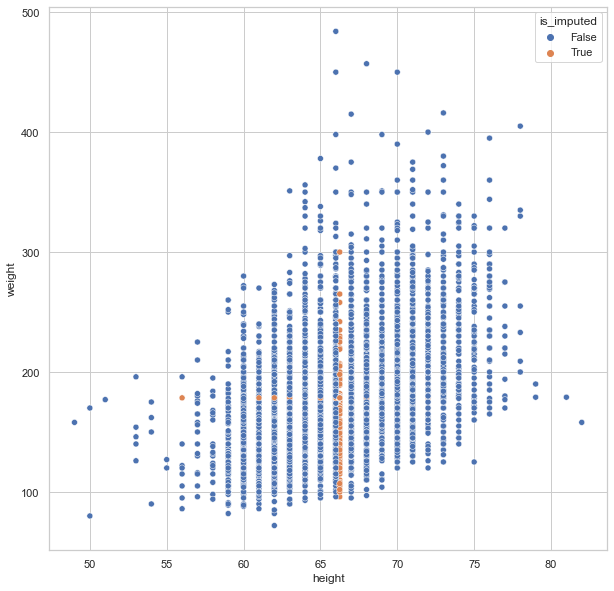

In [45]:
plt.figure(figsize=(10,10))
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix= "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    ).missing.scatter_imputation_plot(
        x="height",
        y="weight"
    )
)

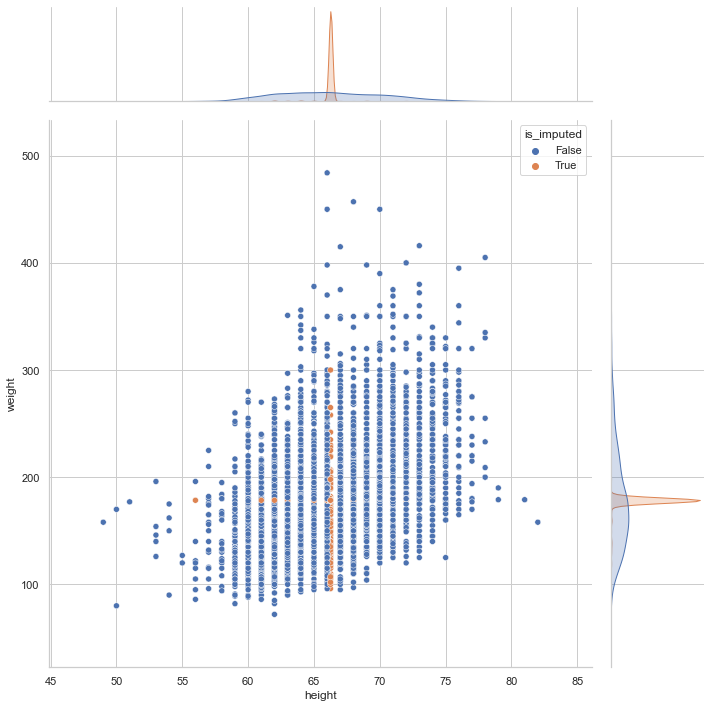

In [46]:
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix= "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    ).missing.scatter_imputation_plot(
        x="height",
        y="weight",
        show_marginal = True,
        height = 10
    )
)

Text(0.5, 1.0, 'Mode')

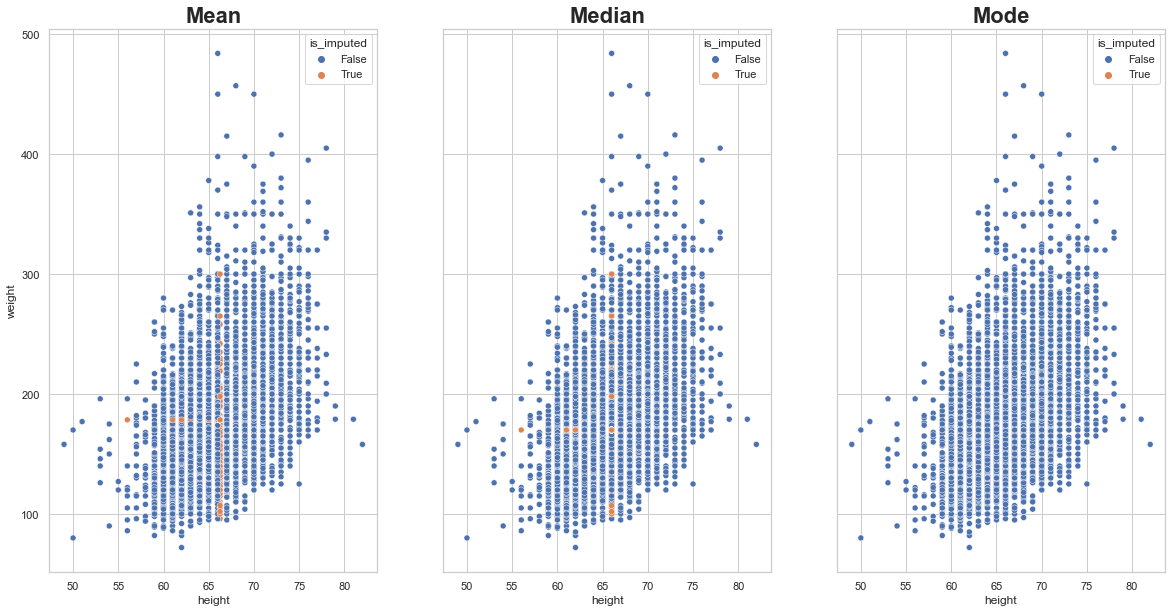

In [92]:
fig, ax = plt.subplots(1,3,figsize=(20,10), sharey=True)
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix= "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    ).missing.scatter_imputation_plot(
        x="height",
        y="weight",
        # show_marginal = True,
        # height = 10,
        ax=ax[0]
    )
),
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix= "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.median()),
        weight = lambda df: df.weight.fillna(value = df.weight.median())
    ).missing.scatter_imputation_plot(
        x="height",
        y="weight",
        # show_marginal = True,
        # height = 10,
        ax=ax[1]
    )
),
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix= "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mode()),
        weight = lambda df: df.weight.fillna(value = df.weight.mode())
    ).missing.scatter_imputation_plot(
        x="height",
        y="weight",
        # show_marginal = True,
        # height = 10,
        ax=ax[2]
    )
),
ax[0].set_title("Mean", fontsize =22, fontweight='bold')
ax[1].set_title("Median", fontsize =22, fontweight='bold')
ax[2].set_title("Mode", fontsize =22, fontweight='bold')

## Imputación por llenado hacia atrás e imputación por llenado hacia adelante

### `fillna()` vs `ffill()` o `bfill()`

#### Recomendaciones al imputar valores utilizando `ffill()` o `bfill()`

> Imputación dentro de dominios e imputación a través de variables correlacionadas

## Imputación por interpolación

## Imputación por algoritmo de vecinos más cercanos (KNN)

### Ordenamiento por cantidad de variables faltantes

## Imputación basada en modelos

## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)

## Transformación inversa de los datos

## Continúa aprendiendo sobre el manejo de valores faltantes

<div class="alert alert-success">
    <b style="font-size: 1.5em;">✅ ¡Felicidades por terminar el curso!</b>
    <p>
    ¡Tu progreso es increíble! ¡Ahora eres capaz de llevar tus análisis al siguiente nivel! La barrera de los valores faltantes ya no es una limitante extrema para tu trabajo. Tú puedes explorar valores faltantes, eliminarlos e imputarlos siendo consciente de las ventajas y desventajas de cada método elegido. ¡Fantástico!
    </p>
    <p>
    <b>¿Cómo puedo continuar mi aprendizaje en el análisis de valores faltantes?</b>
    Poner en práctica lo aprendido es una excelente opción. Por lo tanto, te recomiendo repetir este curso utilizando la totalidad de los datos del <i>National Health and Nutrition Examination Survey</i>. Con este proyecto, serás capaz de explorar y analizar una cantidad de valores faltantes variadas. Podrás probar distintos algoritmos y estrategias. 
    </p>
    <p>
    De tal forma de que, una vez consigas tu conjunto de datos final, puedas proceder a la exploración definitiva del conjunto de datos para extraer ideas y respuestas a preguntas de tu interés. Incluso, y por qué no, podrías explorar la posibilidad de crear modelos predictivos para la diabetes. Las opciones son ilimitadas. Bienvenido al mundo de la Ciencia de Datos.
    </p>
    <p>
    Con mucha alegría por tu logro,
    Jesús Vélez Santiago
    </p>
</div>

## Información de sesión

In [36]:
session_info.show()

KeyError: 'pyarrow'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bdf84ff9-f66c-44c7-a67c-ca1115a2b683' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>